In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/ACSE-9')

In [ ]:
# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import time
from collections import deque

import joblib
import pandas as pd
import time
!pip install vtk -q
import vtktools, tools_io
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file

     |████████████████████████████████| 59.5 MB 37 kB/s 
     |████████████████████████████████| 495 kB 66.6 MB/s 
     |████████████████████████████████| 3.1 MB 64.6 MB/s 
     |████████████████████████████████| 74 kB 4.6 MB/s 
     |████████████████████████████████| 3.2 MB 47.5 MB/s 
     |████████████████████████████████| 251 kB 74.0 MB/s 
     |████████████████████████████████| 1.3 MB 56.4 MB/s 
     |████████████████████████████████| 142 kB 75.7 MB/s 
     |████████████████████████████████| 294 kB 72.6 MB/s 


loading in and preparing data

In [ ]:
enhanced_data = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/enhanced_data_410.pkl')

pca = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/pca_compress_410.pkl')
scaler_minmax = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/scaler_minmax_410.pkl')

scaler_std = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/scaler_std_410.pkl')
scaler_x = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/scaler_x_410.pkl')
scaler_y = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/scaler_y_410.pkl')
scaler_z = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/scaler_z_410.pkl')
scaler_enhanced = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/CO2_scaler_minmax_410.pkl')

CO2data = joblib.load('/content/gdrive/MyDrive/ACSE-9/output_pod_files/CO2data_410.pkl') #snapshot matrix
CO2_sensor = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/sensor_CO2_410.pkl')

CO2_sensor_all = joblib.load('/content/gdrive/MyDrive/ACSE-9/models/sensor_CO2_all.pkl')

In [ ]:
X_train_pca = enhanced_data
print(X_train_pca.shape)
codings_size = X_train_pca.shape[1] #50

(410, 50)


# Scale the enhanced data between [-1, 1]

POD coefficients are not scaled. Scaling them such that you are still representing the space in a more efficient form

True


(array([2003., 1711., 2920., 3782., 4288., 2821., 1356.,  649.,  286.,
         684.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

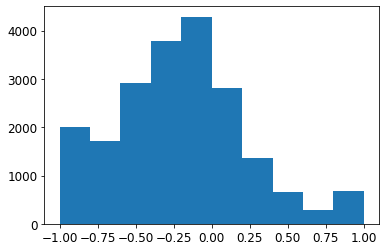

In [ ]:
X_test_scaled = scaler_minmax.transform(X_train_pca)
print(np.allclose(X_train_pca, scaler_minmax.inverse_transform(X_test_scaled)))
plt.hist(X_test_scaled.flatten())

The function `concat_timesteps(X_train, ntimes, step)` takes in a 2D array, picks 9 time levels at a time and skips time levels if needed.  

In [ ]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat) 

In [ ]:
ntimes = 9  # consecutive times for the GAN
step = 1 # step between times

# X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
X_train_concat = concat_timesteps(X_test_scaled, ntimes, step)
print("X_train_concat: ", np.shape(X_train_concat))
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )
print("X_train_concat_flatten: ", X_train_concat_flatten.shape)

X_train_4d = X_train_concat.reshape((X_train_concat.shape[0], ntimes, X_train_concat.shape[2], 1))  #(148706, 100, 81, 1)
print("X_train_4d: ", X_train_4d.shape)

X_train_concat:  (401, 9, 50)
X_train_concat_flatten:  (401, 450)
X_train_4d:  (401, 9, 50, 1)


Loading model

In [ ]:
from tensorflow.keras.models import load_model
generator, discriminator = load_model('/content/gdrive/MyDrive/ACSE-9/models/GAN_model_410_TRY_20000_2.h5', compile=False).layers

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)
npredict = 8
latent_space = 150
noise = tf.random.normal(shape=[npredict, latent_space])
pca_size = 43 # num of POD coefficients

In [ ]:
#CHECKS - delete
latent_values = tf.random.normal([1, latent_space], mean=0.0, stddev=0.01) 
gen_output = generator(latent_values, training=False) 
print(gen_output.shape)
print(gen_output[:,:(ntimes - 1),:pca_size,:].shape)
print(gen_output[:,1:,:,:].shape)

(1, 9, 50, 1)
(1, 8, 43, 1)
(1, 8, 50, 1)


Assimilate data with the GAN

In [ ]:
data_range_ = tf.constant(scaler_minmax.data_range_, dtype=tf.float32)
data_min_ = tf.constant(scaler_minmax.data_min_, dtype=tf.float32)
components_ = tf.constant(pca.components_, dtype=tf.float32)
pca_mean_ = tf.constant(pca.mean_, dtype=tf.float32)

def pod_sse_loss(real_coding, gen_output):
    # -- POD coefficients --
    #
    # apply weights
    inp = tf.reshape(real_coding, [-1, codings_size])[:,:pca_size]*tf.math.sqrt(weight_pod)
    out = tf.reshape(gen_output, [-1, codings_size])[:,:pca_size]*tf.math.sqrt(weight_pod)
    
    pod_loss = tf.reduce_sum(tf.math.squared_difference(inp, out))
    return pod_loss

def obs_sse_loss(real_coding, gen_output):
    # -- Observed sensor data --
    #
    # apply weights
    inp = tf.reshape(real_coding, [-1, codings_size])[:,pca_size:]*tf.math.sqrt(weight_obs)
    out = tf.reshape(gen_output, [-1, codings_size])[:,pca_size:]*tf.math.sqrt(weight_obs)
    
    obs_loss = tf.reduce_sum(tf.math.squared_difference(inp, out))
    return obs_loss

# def obs_sse_loss(gen_output, obs_data): 
#     # -- Observed data --
#     # 
#     if obs_data.shape[0]>0:
#         # scaler.inverse_transform -> undoing (-1, 1) scaling
#         gen_output_scaled = tf.reshape(gen_output, [-1, codings_size]) 
#         gen_output = gen_output_scaled * data_range_ + data_min_
#         # print("undoing (-1,1) scaling, gen_output.max(): ", gen_output.max(), " gen_output.min(): ", gen_output.min())

#         # splitting pod coefficients from sensor location vals
#         alpha = gen_output[:, :pca_size]
#         sensor_CO2 = gen_output[:, pca_size:]

#         # pca.inverse_transform
#         # X_generated = tf.reshape(gen_output_scaled[:,:pca_size]@components_+pca_mean_, (len(gen_output_scaled), len(groups), nl, nc))
#         # X_generated = pca.inverse_transform(alpha) ??
#         X_generated = alpha @ components_ + pca_mean_

#         # i dont need to split because obs will just be the sensor CO2 val columns

#         # # get the data points
#         # sim_data = tf.gather_nd(X_generated, obs_points_inrange)
#         sim_data = tf.cast(sensor_CO2, dtype=tf.float32)
#         print("shape:", sim_data.shape)
#         obs_data = obs_data[:,(ntimes-1)]
#         obs_loss = tf.reduce_sum(tf.math.squared_difference(obs_data, sim_data))*weight_obs/tf.size(obs_data, out_type=tf.float32) 
#     else:
#         obs_loss = 0
        
#     return obs_loss

def optimize_coding_forward_onlyPOD(latent_values, real_coding, epochs=1000):
    
    optimizer = tf.keras.optimizers.Adam(1e-2)
    
    @tf.function
    # def opt_step_forward(optimizer, latent_values, real_coding, obs_data, obs_points_inrange):
    def opt_step_forward(optimizer, latent_values, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = generator(latent_values, training=False) 

            pod_loss = pod_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   
            obs_loss = obs_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   
            # obs_loss = obs_sse_loss(gen_output[:,:(ntimes - 1),:,:], obs_data, obs_points_inrange)
            loss = pod_loss 

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  

        return loss, pod_loss, obs_loss  
    
    loss = []
    for epoch in range(epochs):
        # loss.append(opt_step_forward(optimizer, latent_values, real_coding, obs_data, obs_points_inrange))
        loss.append(opt_step_forward(optimizer, latent_values, real_coding))
         
    #plt.plot(loss)
    #plt.grid()
    #plt.show
        
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output


# def optimize_coding_forward(latent_values, real_coding, obs_data, epochs=1000):
def optimize_coding_forward(latent_values, real_coding, epochs=1000):
    optimizer = tf.keras.optimizers.Adam(1e-2)
    
    @tf.function
    # def opt_step_forward(optimizer, latent_values, real_coding, obs_data):
    def opt_step_forward(optimizer, latent_values, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = generator(latent_values, training=False) 

            pod_loss = pod_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   
            obs_loss = obs_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   
            # obs_loss = obs_sse_loss(gen_output[:,:(ntimes - 1),:,:], obs_data)
            loss = pod_loss + obs_loss 

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  

        return loss, pod_loss, obs_loss
    
    loss = []
    for epoch in range(epochs):
        # loss.append(opt_step_forward(optimizer, latent_values, real_coding, obs_data))
        loss.append(opt_step_forward(optimizer, latent_values, real_coding))
        
    #plt.plot(loss)
    #plt.grid()
    #plt.show
        
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output

# def optimize_coding_backward(latent_values, real_coding, obs_data, epochs=1000):
def optimize_coding_backward(latent_values, real_coding, epochs=1000):
    
    optimizer = tf.keras.optimizers.Adam(1e-2)
    
    @tf.function
    # def opt_step_backward(optimizer, latent_values, real_coding, obs_data):
    def opt_step_backward(optimizer, latent_values, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = generator(latent_values, training=False) 
            pod_loss = pod_sse_loss(real_coding, gen_output[:,1:,:,:])   
            obs_loss = obs_sse_loss(real_coding, gen_output[:,1:,:,:])   
            # obs_loss = obs_sse_loss(gen_output[:,1:,:,:], obs_data)
            loss = pod_loss + obs_loss 

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  

        return loss, pod_loss, obs_loss 
    
    loss = []
    for epoch in range(epochs):
        # loss.append(opt_step_backward(optimizer, latent_values, real_coding, obs_data))
        loss.append(opt_step_backward(optimizer, latent_values, real_coding))
        
    #plt.plot(loss)
    #plt.grid()
    #plt.show
        
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output


# def process_obs_data(march_range, X_obs):
#     # Process the observed data to be in the range of the forward/backward march
    
#     X_obs_inrange = X_obs[march_range, :]
#     # obs_points_inrange = np.array([x-np.array([march_range[0], 0, 0, 0]) for x in obs_points if x[0] in march_range])
#     # if obs_points_inrange.size>0:
#     #     obs_data = tf.gather_nd(X_obs_inrange, obs_points_inrange)
#     # else:
#     #     obs_data = []

#     # obs_points_inrange = tf.constant(obs_points_inrange)
#     # obs_points_inrange = tf.cast(obs_points_inrange, dtype=tf.int32)
#     obs_data = tf.constant(X_obs)
#     obs_data = tf.cast(obs_data, dtype=tf.float32)
    
#     return obs_data

# def plot_data(X_predict, nx, ny, obs_times=[], X_obs=[], grid_points=[], R0s_obs=[], R0_ax='', X_ax='', label='', mark='-'):
#     X_generated = scaler.inverse_transform(X_predict)
#     R0_generated = X_generated[:,pca_size:]
#     X_generated = pca_compress.inverse_transform(X_generated[:,:pca_size])
#     X_generated = X_generated.reshape(len(X_predict), len(groups), nl, nc)
#     X_generated[X_generated<0] = 0 
    
#     # Plot R
#     xp = len(R0_generated)
#     if R0_ax: 
#         R0_ax.plot(np.linspace(0,(xp-1)*8000/86400,xp), R0_generated[:,0], 'b'+mark, label='Home '+label)
#         R0_ax.plot(np.linspace(0,(xp-1)*8000/86400,xp), R0_generated[:,1], 'r'+mark, label='Mobile '+label)
#         if len(R0s_obs):
#             R0_ax.plot(np.linspace(0,(xp-1)*8000/86400,xp), [R0s_obs[0]]*xp, 'bo', markevery=1, fillstyle='none', markersize = 10, label='Home truth')
#             R0_ax.plot(np.linspace(0,(xp-1)*8000/86400,xp), [R0s_obs[1]]*xp, 'ro', markevery=1, fillstyle='none', markersize = 10, label='Mobile truth')    
#         if len(label):
#         #    R0_ax.legend()
#             R0_ax.set_xlabel('Time (days)')
#             R0_ax.set_ylabel('Reproduction number')
#         plt.tight_layout()
#         #plt.grid()
#         #plt.show()

    
#     # Plot groups 
#     if len(X_ax): 
#         for i, group in enumerate(groups):
#             X_ax.flatten()[i].plot(np.linspace(0,(xp-1)*8000/86400,xp), X_generated[:,i, nx, ny], mark, label=label)
#             if len(X_obs):
#                 if [i, nx, ny] in grid_points:
#                     X_ax.flatten()[i].plot(np.array(obs_times)*8000/86400, X_obs[:, i, nx, ny], 'o', markevery=1, fillstyle='none', markersize = 8, label='Observed data')
#                 else:
#                     X_ax.flatten()[i].plot([],[])
#             X_ax.flatten()[i].set_title(group)
#             if len(label):
#             #    X_ax.flatten()[i].legend()
#                 X_ax.flatten()[i].set_xlabel('Time (days)')
#                 X_ax.flatten()[i].set_ylabel('Number of People')
#         plt.tight_layout()
#         #plt.grid()
#         #plt.show()

Test Case 1 </br>
Generate Data

In [ ]:
# Get observed data
X_obs = CO2_sensor
obs_data = CO2_sensor
forward_steps = 447 #101 #15 #10
time_steps = forward_steps + (ntimes-1)

# Add noise
noise = 0.05
X_obs = X_obs + np.random.standard_normal(X_obs.shape)*noise*X_obs
X_obs = X_obs

print('X_obs shape: ', X_obs.shape)

#Time for X_obs to be considered for data assimilation
obs_times = list(range(0, len(X_obs[:])))

# Sensor locations at each time level
flat_enh = enhanced_data.flatten()
print(flat_enh.shape)
#obs = [43, 44, 45, 46, 47, 48, 49]
#obs_points = np.arange(43,50,1) #for indexing the last 7 columns of the enhanced data matrix

obs_points = X_obs

X_obs shape:  (410, 7)
(20500,)


In [ ]:
pca.singular_values_/pca.singular_values_.sum()

array([0.17910983, 0.13741056, 0.0722906 , 0.06101598, 0.04234028,
       0.03981384, 0.03507182, 0.03404849, 0.03004818, 0.02640378,
       0.02500011, 0.0234906 , 0.02077348, 0.01919904, 0.01811404,
       0.01650185, 0.01572904, 0.01403957, 0.01341072, 0.01233195,
       0.01180369, 0.01066451, 0.01030029, 0.01012792, 0.00921298,
       0.00852363, 0.00816752, 0.00792704, 0.0075567 , 0.00746498,
       0.00693216, 0.00659949, 0.00635733, 0.00627328, 0.0059875 ,
       0.00577715, 0.00550939, 0.00533578, 0.0050399 , 0.00476178,
       0.00465464, 0.00453223, 0.00434632])

In [ ]:
# Initial condition

# Calculate the weights
# Delta variables 
delta_obs = 120
delta_pod = 2

# POD coefficients
weights = np.ones(shape=(43,))
# weight_pod = tf.constant(weights, dtype=tf.float32) #decrease this value 
# weight_pod = 0.01*tf.constant(weights, dtype=tf.float32) #decrease this value 

weight_pod = 0.1*pca.singular_values_/pca.singular_values_.sum()
weight_pod = tf.constant(weight_pod, dtype=tf.float32)
print('weight_pod: ', weight_pod, end='\n\n')

# Observed data
# weight_obs = 10.0*((delta_pod/delta_obs)**2)*ntimes
weight_obs = 1.0*((delta_pod/delta_obs)**2)*ntimes #increase this value
weight_obs = tf.constant(weight_obs, dtype=tf.float32)
print('weight_obs', weight_obs, end='\n\n')

weight_pod:  tf.Tensor(
[0.01791098 0.01374106 0.00722906 0.0061016  0.00423403 0.00398138
 0.00350718 0.00340485 0.00300482 0.00264038 0.00250001 0.00234906
 0.00207735 0.0019199  0.0018114  0.00165019 0.0015729  0.00140396
 0.00134107 0.0012332  0.00118037 0.00106645 0.00103003 0.00101279
 0.0009213  0.00085236 0.00081675 0.0007927  0.00075567 0.0007465
 0.00069322 0.00065995 0.00063573 0.00062733 0.00059875 0.00057772
 0.00055094 0.00053358 0.00050399 0.00047618 0.00046546 0.00045322
 0.00043463], shape=(43,), dtype=float32)

weight_obs tf.Tensor(0.0025, shape=(), dtype=float32)



Run data assimilation

Streaming output truncated to the last 5000 lines.
Loss iteration 416: ['1.71e-02', '1.69e-02', '2.05e-04'] - 1s
Loss iteration 417: ['1.71e-02', '1.69e-02', '2.08e-04'] - 1s
Loss iteration 418: ['1.72e-02', '1.70e-02', '2.12e-04'] - 1s
Loss iteration 419: ['1.72e-02', '1.70e-02', '2.16e-04'] - 1s
Loss iteration 420: ['1.72e-02', '1.70e-02', '2.21e-04'] - 1s
Loss iteration 421: ['1.72e-02', '1.70e-02', '2.22e-04'] - 1s
Loss iteration 422: ['1.72e-02', '1.70e-02', '2.23e-04'] - 1s
Loss iteration 423: ['1.72e-02', '1.69e-02', '2.25e-04'] - 1s
Loss iteration 424: ['1.72e-02', '1.69e-02', '2.29e-04'] - 1s
Loss iteration 425: ['1.72e-02', '1.70e-02', '2.30e-04'] - 1s
Loss iteration 426: ['1.72e-02', '1.70e-02', '2.33e-04'] - 1s
Loss iteration 427: ['1.72e-02', '1.70e-02', '2.38e-04'] - 1s
Loss iteration 428: ['1.72e-02', '1.69e-02', '2.46e-04'] - 1s
Loss iteration 429: ['1.72e-02', '1.69e-02', '2.48e-04'] - 1s
Loss iteration 430: ['1.72e-02', '1.69e-02', '2.48e-04'] - 1s
Loss iteration 431:

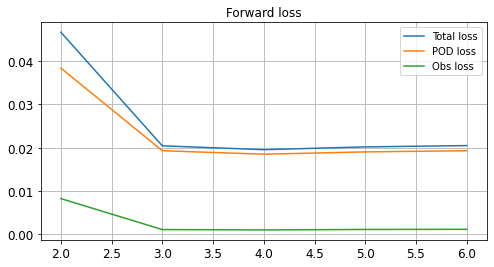

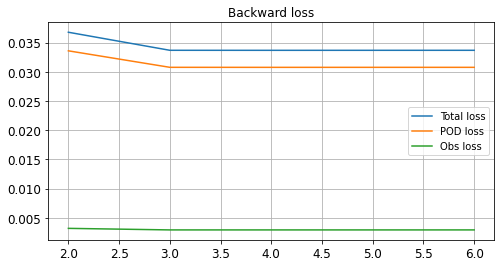

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

list_X_predict_forward = []
list_X_predict_backward = []
list_relax = []

# Forward and backward march   
forward_loss = []
backward_loss = []
forward_onlyPOD_loss = []
relax = 1.0
alltimes = 447
for j in range(100):    
    print(f'\nIteration {j}: forward and backward')
    latent_values_forward = []
    latent_values_backward = []
    
    #===========================================
    # Forward march 
    #===========================================
    print('-- Forward March --')
    
    march_range = np.arange(0,(ntimes-1))
    #march_range = np.arange(0, alltimes)
    # obs_data, obs_points_inrange = process_obs_data(march_range, X_obs)
    # obs_data = process_obs_data(march_range, X_obs)
    loss_iteration = []
    
    if j == 0: # If the first forward march
        # For the first forward march
        n = 0

        real_coding = X_train_concat[n]#.reshape(1,-1)
        real_coding = real_coding[:-1,:]
        obs_run = real_coding[0,-7:]
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)
        
        list_latent_values = []
        list_loss = []
        for _ in range(10):
            latent_values = tf.random.normal([1, latent_space], mean=0.0, stddev=0.01)  
            latent_values = tf.Variable(latent_values) 
            # latent_values, loss = optimize_coding_forward_onlyPOD(latent_values, real_coding, obs_data, epochs=1000)
            latent_values, loss = optimize_coding_forward_onlyPOD(latent_values, real_coding, epochs=300)
            list_latent_values.append(latent_values)
            list_loss.append(loss)
        latent_values = list_latent_values[np.argmin(list_loss,axis=0)[0]]
        loss_iteration.append(list(map(float,list_loss[np.argmin(list_loss,axis=0)[0]])))
        print('Initial point losses: ', end='\n')
        for l in list_loss:
            print(['{0:1.2e}'.format(float(x)) for x in l])
        print()
        print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in list_loss[np.argmin(list_loss,axis=0)[0]]]), end='\n')        

        latent_values_forward.append(latent_values.value())
        X_predict_forward = list(generator(latent_values).numpy().reshape(-1,codings_size))
        gen_predict = X_predict_forward[-1]
        gen_predict[-7:] = obs_run  
    
    else: # If not the first forward march
        real_coding = X_predict_backward[0:(ntimes-1),:].copy()
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)  
        
        # latent_values, loss = optimize_coding_forward(latent_values, real_coding, obs_data, epochs=1000)
        latent_values, loss = optimize_coding_forward(latent_values, real_coding, epochs=300)
        if j != 0:
            latent_values = tf.Variable((1-relax)*latent_values_forward_old[0] + relax*latent_values.value())
        loss_iteration.append(list(map(float,loss)))
        print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end='\n')
    
        latent_values_forward.append(latent_values.value())
        X_predict_forward = list(generator(latent_values).numpy().reshape(-1,codings_size))
        gen_predict = X_predict_forward[-1]

    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    
    for i in range(1, forward_steps): 
        march_range = np.arange(i,(ntimes-1)+i)
        #march_range = np.arange(0, alltimes)
        # obs_data = process_obs_data(march_range, X_obs, obs_points)
        
        start = time.time()
        if j == 0:    
            # latent_values, loss = optimize_coding_forward_onlyPOD(latent_values, real_coding, obs_data, epochs=1000)
            latent_values, loss = optimize_coding_forward_onlyPOD(latent_values, real_coding, epochs=300)
        
            loss_iteration.append(list(map(float,loss)))
            print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

            latent_values_forward.append(latent_values.value())
            gen_predict = generator(latent_values).numpy().reshape(-1,codings_size)[-1]
            X_predict_forward.append(gen_predict.copy())
            gen_predict[-7:] = obs_run        
        
        else:
            # latent_values, loss = optimize_coding_forward(latent_values, real_coding, obs_data, epochs=1000)
            latent_values, loss = optimize_coding_forward(latent_values, real_coding, epochs=300)
            latent_values = tf.Variable((1-relax)*latent_values_forward_old[i] + relax*latent_values.value())
        
            loss_iteration.append(list(map(float,loss)))
            print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

            latent_values_forward.append(latent_values.value())
            gen_predict = generator(latent_values).numpy().reshape(-1,codings_size)[-1]
            X_predict_forward.append(gen_predict.copy())

        real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)
        print ('{:.0f}s'.format( time.time()-start))
    X_predict_forward = np.array(X_predict_forward)
    if j == 0:
        X_predict_forward_first = X_predict_forward
        # weight_R0.assign(weight_R0_da)
    forward_loss.append(np.array(loss_iteration).mean(axis=0))
    print('Loss iteration mean:', ['{0:1.2e}'.format(float(x)) for x in np.array(loss_iteration).mean(axis=0)])
        

    #===========================================
    # Backward march
    #===========================================
    print('-- Backward March --')
    
    march_range = np.arange(time_steps-(ntimes-1),time_steps)
    #march_range = np.arange(0, alltimes)
    # obs_data = process_obs_data(march_range, X_obs)    
    loss_iteration = []
    
    real_coding = X_predict_forward[time_steps-(ntimes-1):time_steps,:].copy()
    if j ==0:
    #     real_coding[:,-2:] = R0s_run
          real_coding[:,-7:] = obs_run
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)  
    
    # latent_values, loss = optimize_coding_backward(latent_values, real_coding, obs_data, epochs=1000)
    latent_values, loss = optimize_coding_backward(latent_values, real_coding, epochs=300)
    if j != 0:
        latent_values = tf.Variable((1-relax)*latent_values_backward_old[0] + relax*latent_values.value())
    loss_iteration.append(list(map(float,loss)))
    print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end='\n')

    latent_values_backward.append(latent_values.value())
    X_predict_backward = deque(generator(latent_values).numpy().reshape(-1,codings_size))
    gen_predict = X_predict_backward[0]

    real_coding = np.concatenate((gen_predict.reshape(1,-1), real_coding), axis=0)[:-1,:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    
    for i in range(1, forward_steps): 
        march_range = np.arange(time_steps-(ntimes-1)-i,time_steps-i)
        #march_range = np.arange(0, alltimes)
        # obs_data = process_obs_data(march_range, X_obs)        
        
        start = time.time()
        # latent_values, loss = optimize_coding_backward(latent_values, real_coding, obs_data, epochs=1000)
        latent_values, loss = optimize_coding_backward(latent_values, real_coding, epochs=300)
        if j != 0:
            latent_values = tf.Variable((1-relax)*latent_values_backward_old[i] + relax*latent_values.value())
        loss_iteration.append(list(map(float,loss)))
        print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

        latent_values_backward.append(latent_values.value())
        gen_predict = generator(latent_values).numpy().reshape(-1,codings_size)[0]
        X_predict_backward.appendleft(gen_predict.copy())

        real_coding = np.concatenate((gen_predict.reshape(1,-1), real_coding), axis=0)[:-1,:]
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)
        print ('{:.0f}s'.format( time.time()-start))
    X_predict_backward = np.array(X_predict_backward)
    backward_loss.append(np.array(loss_iteration).mean(axis=0))
    print('Loss iteration mean:', ['{0:1.2e}'.format(float(x)) for x in np.array(loss_iteration).mean(axis=0)])
    
    # # Update the R0 weights
    # if j<100:
    #     weight_R0.assign(weight_R0*1.2)
    # print('weight_R0: ', weight_R0)

    # Save relaxation
    list_relax.append(relax)
    
    # Update relaxation
    epsilon = 1.01
    loss_obs = (forward_loss[-1][-1] + backward_loss[-1][-1])/2 
    print(f'Loss obs: {loss_obs}')
    if j == 0:
        loss_obs_old = loss_obs        
        latent_values_forward_old = latent_values_forward.copy()
        latent_values_backward_old = latent_values_backward.copy()
        X_predict_backward_old = X_predict_backward.copy()
        # weight_R0_old = tf.identity(weight_R0)
    else:
        print(f'Loss obs old: {loss_obs_old}')
        print(f'Relax old: {relax}, new ', end='')
        if (loss_obs - loss_obs_old*epsilon) < 0:
            loss_obs_old = loss_obs
            X_predict_backward_old = X_predict_backward.copy()
            latent_values_forward_old = latent_values_forward.copy()
            latent_values_backward_old = latent_values_backward.copy()
            # weight_R0_old = tf.identity(weight_R0)
            relax *= 1.5
            if relax > 1.0: 
                relax = 1.0              
        else:
            relax *= 0.5
            if relax < 0.05: 
                print(relax)
                print('Converged!')
                # plot loss functions
                fig, ax = plt.subplots(1,1, figsize=[8,4])
                ax.plot(np.arange(2,len(forward_loss)), forward_loss[2:])
                ax.set_title('Forward loss')
                #ax.set_yscale('log')
                #ax.set_ylim([0,20000])
                plt.grid()
                plt.legend(['Total loss','POD loss','Obs loss'])    
                fig, ax = plt.subplots(1,1, figsize=[8,4])
                ax.plot(np.arange(2,len(backward_loss)), backward_loss[2:])
                #ax.set_yscale('log')
                ax.set_title('Backward loss')
                #ax.set_ylim([0,20000])
                plt.grid()
                plt.legend(['Total loss','POD loss','Obs loss'])
                break
            X_predict_backward = X_predict_backward_old
            latent_values_forward = latent_values_forward_old
            latent_values_backward = latent_values_backward_old
            # weight_R0.assign(weight_R0_old)
        print(relax)
        
            
    # Only for debugging
    #list_obs_data_backward.append(obs_data.numpy().copy()) 
    #list_points_inrange_backward.append(obs_points_inrange.numpy().copy())
    #list_latent_values_backward.append(latent_values.numpy().copy())  
    
    
    list_X_predict_forward.append(X_predict_forward)
    list_X_predict_backward.append(X_predict_backward)
    
    # #===============
    # # Plots
    # #===============   
    # # plot loss function
    # fig, ax = plt.subplots(1,1, figsize=[8,4])
    # ax.plot(forward_loss)
    # ax.set_title('Forward loss')
    # ax.set_yscale('log')
    # plt.grid()
    # plt.legend(['Total loss','POD loss','R0s loss','Obs loss'])    
    # fig, ax = plt.subplots(1,1, figsize=[8,4])
    # ax.plot(backward_loss)
    # ax.set_yscale('log')
    # ax.set_title('Backward loss')
    # plt.grid()
    # plt.legend(['Total loss','POD loss','R0s loss','Obs loss'])
    
    # # Plot forward and backward march   
    # mpl.rcParams.update({'font.size': 18})
    # mpl.rc('xtick', labelsize=18) 
    # mpl.rc('ytick', labelsize=18) 
    # mpl.rc('axes', labelsize=18)
    
    # fig, R0_ax = plt.subplots(1,1, figsize=[8,4])
    # fig, X_ax = plt.subplots(4,2, figsize=[10,10])
    # plot_data(X_predict_forward, 0, 4, obs_times, X_obs[obs_times], grid_points, R0s_obs, R0_ax=R0_ax, X_ax=X_ax, label='', mark='--')
    # plot_data(X_predict_backward, 0, 4, R0_ax=R0_ax, X_ax=X_ax, label='', mark=':')
    
    # fig, X_ax1 = plt.subplots(4,2, figsize=[10,10])
    # plot_data(X_predict_forward, 9, 4, obs_times, X_obs[obs_times], grid_points, R0_ax='', X_ax=X_ax1, label='', mark='--')
    # plot_data(X_predict_backward, 9, 4, X_ax=X_ax1, label='', mark=':')

    # fig, X_ax2 = plt.subplots(4,2, figsize=[10,10])
    # plot_data(X_predict_forward, 4, 4, obs_times, X_obs[obs_times], grid_points, R0_ax='', X_ax=X_ax2, label='', mark='--')
    # plot_data(X_predict_backward, 4, 4, X_ax=X_ax2, label='', mark=':')

    # fig, X_ax3 = plt.subplots(4,2, figsize=[10,10])
    # plot_data(X_predict_forward, 4, 0, obs_times, X_obs[obs_times], grid_points, R0_ax='', X_ax=X_ax3, label='', mark='--')
    # plot_data(X_predict_backward, 4, 0, X_ax=X_ax3, label='', mark=':')

    # fig, X_ax4 = plt.subplots(4,2, figsize=[10,10])
    # plot_data(X_predict_forward, 4, 9, obs_times, X_obs[obs_times], grid_points, R0_ax='', X_ax=X_ax4, label='', mark='--')
    # plot_data(X_predict_backward, 4, 9, X_ax=X_ax4, label='', mark=':')        
    # plt.show()     

In [ ]:
#===========================================
# Last time stepping forward march
#===========================================
print('-- Last time Stepping Forward March --')

#weight_R0.assign(weight_R0_p) 
march_range = np.arange(0,(ntimes-1))
#march_range = np.arange(0, alltimes)
#obs_data, obs_points_inrange = process_obs_data(march_range, X_obs, obs_points)
loss_iteration = []

real_coding = X_predict_backward[0:(ntimes-1),:].copy()
obs_run = real_coding[0,-7:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)  

latent_values_onlyPOD = tf.Variable(latent_values)
latent_values_onlyPOD, loss = optimize_coding_forward_onlyPOD(latent_values_onlyPOD, real_coding, epochs=1000)
loss_iteration.append(list(map(float,loss)))
print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end='\n')

X_predict_forward_last = list(generator(latent_values_onlyPOD).numpy().reshape(-1,codings_size))
gen_predict = X_predict_forward_last[-1]
gen_predict[-7:] = obs_run

real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(1, forward_steps): 
    march_range = np.arange(i,(ntimes-1)+i)
    #march_range = np.arange(0, alltimes)
    #obs_data, obs_points_inrange = process_obs_data(march_range, X_obs, obs_points)

    start = time.time()
    latent_values_onlyPOD, loss = optimize_coding_forward_onlyPOD(latent_values_onlyPOD, real_coding, epochs=300)
    loss_iteration.append(list(map(float,loss)))
    print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

    gen_predict = generator(latent_values_onlyPOD).numpy().reshape(-1,codings_size)[-1]
    X_predict_forward_last.append(gen_predict.copy())
    gen_predict[-7:] = obs_run

    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print ('{:.0f}s'.format( time.time()-start))
X_predict_forward_last = np.array(X_predict_forward_last)
forward_onlyPOD_loss.append(np.array(loss_iteration).mean(axis=0))
print('Loss iteration mean:', ['{0:1.2e}'.format(float(x)) for x in np.array(loss_iteration).mean(axis=0)])

# # Plot forward and backward march   
# mpl.rcParams.update({'font.size': 18})
# mpl.rc('xtick', labelsize=18) 
# mpl.rc('ytick', labelsize=18) 
# mpl.rc('axes', labelsize=18)

# fig, R0_ax = plt.subplots(1,1, figsize=[8,4])
# plot_data(X_predict_forward_first, 0, 4,  obs_times, X_obs[obs_times], grid_points, R0s_obs, R0_ax=R0_ax, X_ax='', label='Initial', mark='--')
# plot_data(X_predict_forward_last, 0, 4, R0_ax=R0_ax, X_ax='', label='Final', mark='-')

# fig, X_ax = plt.subplots(2,4, figsize=[20,10])
# plot_data(X_predict_forward_first, 0, 4, obs_times, X_obs[obs_times], grid_points, R0s_obs, R0_ax='', X_ax=X_ax, label='Initial', mark='--')
# plot_data(X_predict_forward_last, 0, 4, R0_ax='', X_ax=X_ax, label='Final', mark='-')

# fig, X_ax1 = plt.subplots(2,4, figsize=[20,10])
# plot_data(X_predict_forward_first, 9, 4, obs_times, X_obs[obs_times], grid_points, R0_ax='', X_ax=X_ax1, label='Initial', mark='--')
# plot_data(X_predict_forward_last, 9, 4, X_ax=X_ax1, label='Final', mark='-')

# fig, X_ax2 = plt.subplots(2,4, figsize=[20,10])
# plot_data(X_predict_forward_first, 4, 4, obs_times, X_obs[obs_times], grid_points, R0_ax='', X_ax=X_ax2, label='Initial', mark='--')
# plot_data(X_predict_forward_last, 4, 4, X_ax=X_ax2, label='Final', mark='-')

# fig, X_ax3 = plt.subplots(2,4, figsize=[20,10])
# plot_data(X_predict_forward_first, 4, 0, obs_times, X_obs[obs_times], grid_points, R0_ax='', X_ax=X_ax3, label='Initial', mark='--')
# plot_data(X_predict_forward_last, 4, 0, X_ax=X_ax3, label='Final', mark='-')

# fig, X_ax4 = plt.subplots(2,4, figsize=[20,10])
# plot_data(X_predict_forward_first, 4, 9, obs_times, X_obs[obs_times], grid_points, R0_ax='', X_ax=X_ax4, label='Initial', mark='--')
# plot_data(X_predict_forward_last, 4, 9, X_ax=X_ax4, label='Final', mark='-')        
# plt.show() 

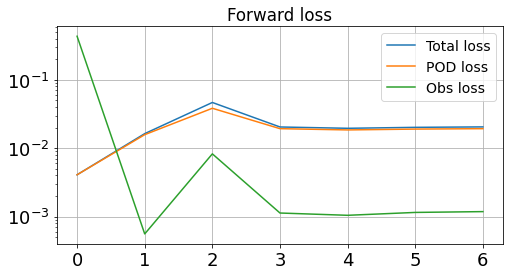

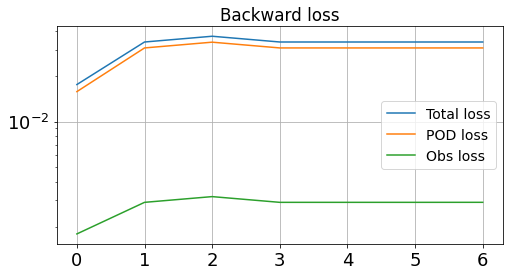

In [ ]:
# plot loss function 
mpl.rcParams.update({'font.size': 14})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)

fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(forward_loss)
ax.set_title('Forward loss')
ax.set_yscale('log')
plt.grid()
plt.legend(['Total loss','POD loss','Obs loss'])    
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(backward_loss)
ax.set_yscale('log')
ax.set_title('Backward loss')
plt.grid()
plt.legend(['Total loss','POD loss','Obs loss'])

0 [0.01084234 0.00994166 0.21761902]
1 [0.02500327 0.02326612 0.00173715]
2 [0.02500327 0.02326612 0.00173715]
3 [0.02500327 0.02326612 0.00173715]
4 [0.02500327 0.02326612 0.00173715]
5 [0.02500327 0.02326612 0.00173715]
6 [0.02500327 0.02326612 0.00173715]


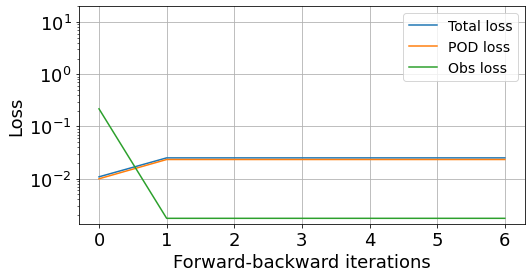

In [ ]:
loss = (np.array(backward_loss)+np.array(forward_loss))/2
new_loss = loss.copy()

# Because we discard the forward-backward iteration with loss greater than the minimum
print(0, new_loss[0,:])
for i in range(1,len(new_loss)):
    if new_loss[i,-1] > new_loss[i-1,-1]:
        new_loss[i,:] = new_loss[i-1,:] 
    print(i, new_loss[i,:])
    
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(new_loss)
ax.set_yscale('log')
ax.set_ylim(top=2*10**1)
ax.set_ylabel('Loss') 
ax.set_xlabel('Forward-backward iterations')   
plt.grid()
plt.legend(['Total loss','POD loss','Obs loss'])

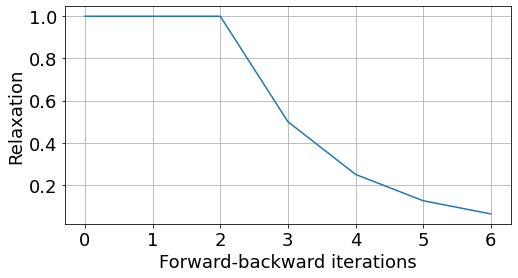

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(list_relax)
ax.set_ylabel('Relaxation') 
ax.set_xlabel('Forward-backward iterations')   
plt.grid()

In [ ]:
X_predict_forward_last.shape

(455, 50)

First forward pass

In [ ]:
GAN_inverse = scaler_minmax.inverse_transform(X_predict_forward_first)#.reshape((455,50))
# GAN_inverse = scaler_minmax.inverse_transform(X_predict_TEST).reshape((455,50))
print(GAN_inverse.shape)
split_inv = np.split(GAN_inverse, [43, ], axis=1)
alpha = split_inv[0]
print(alpha.shape)
sensor_CO2 = split_inv[-1]

print("GAN shape output of sensor CO2: ", sensor_CO2.shape)
 
X_recovered = pca.inverse_transform(alpha)
print(X_recovered.shape)

X_unscaled = np.split(X_recovered, [int(X_recovered.shape[-1]/4), int(X_recovered.shape[-1]/2), int(X_recovered.shape[-1]*(3/4)), ], axis=1)

norm_co2_ = scaler_std.inverse_transform(X_unscaled[0])
norm_x_ = scaler_x.inverse_transform(X_unscaled[1])
norm_y_ = scaler_y.inverse_transform(X_unscaled[2])
norm_z_ = scaler_z.inverse_transform(X_unscaled[-1])
norm_sensor_CO2_ = scaler_enhanced.inverse_transform(sensor_CO2)

print("norm_co2_ shape: ", norm_co2_.shape)
print("norm_z_ shape: ", norm_z_.shape)
print("norm_sensor_CO2_ shape: ", norm_sensor_CO2_.shape)

(455, 50)
(455, 43)
GAN shape output of sensor CO2:  (455, 7)
(455, 595624)
norm_co2_ shape:  (455, 148906)
norm_z_ shape:  (455, 148906)
norm_sensor_CO2_ shape:  (455, 7)


DA-pred results - time: 17:00pm, 09-08-2021


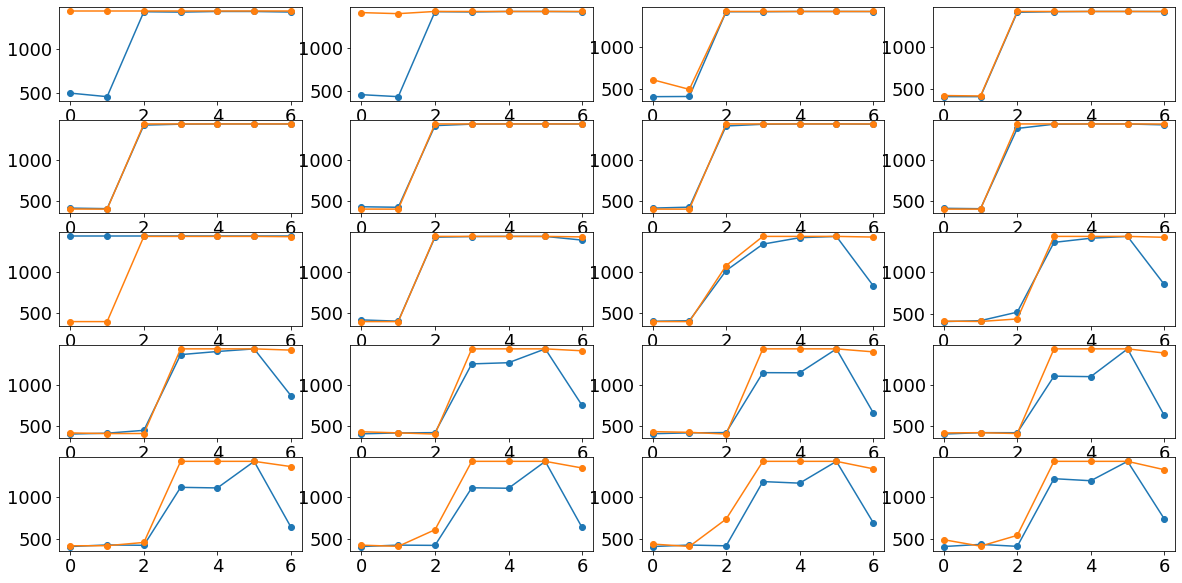

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[i,:], '-o')

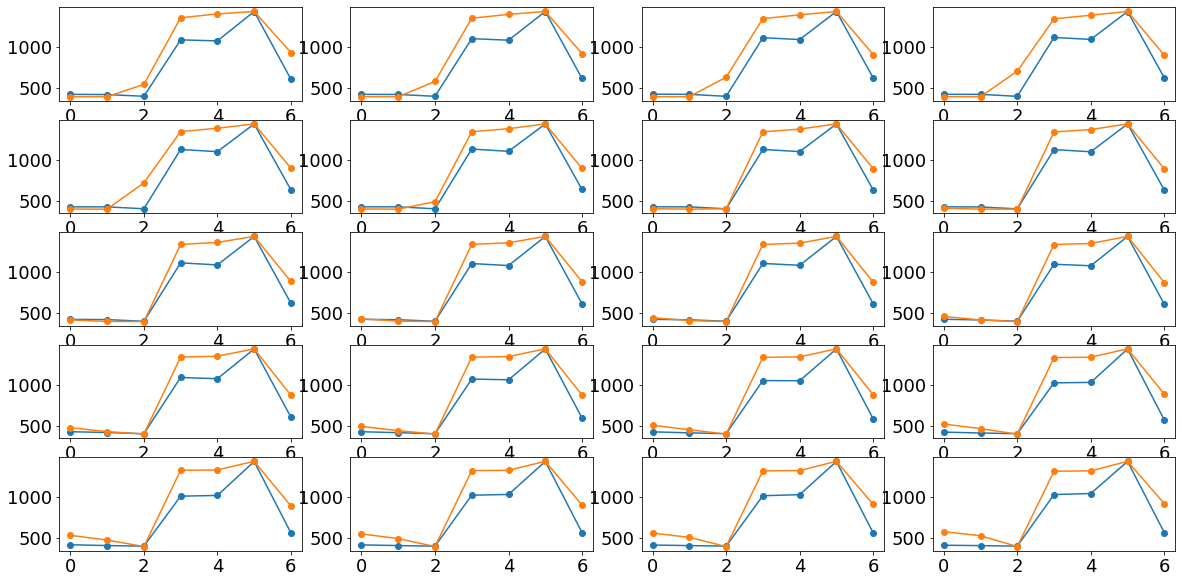

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[80+i,:], '-o')

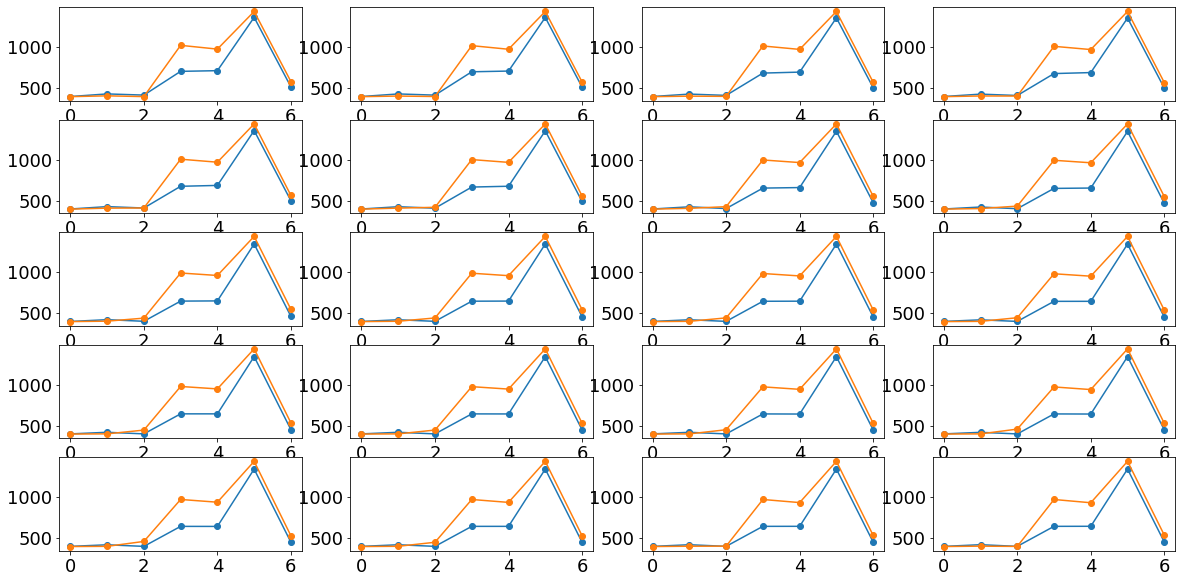

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[200+i,:], '-o')

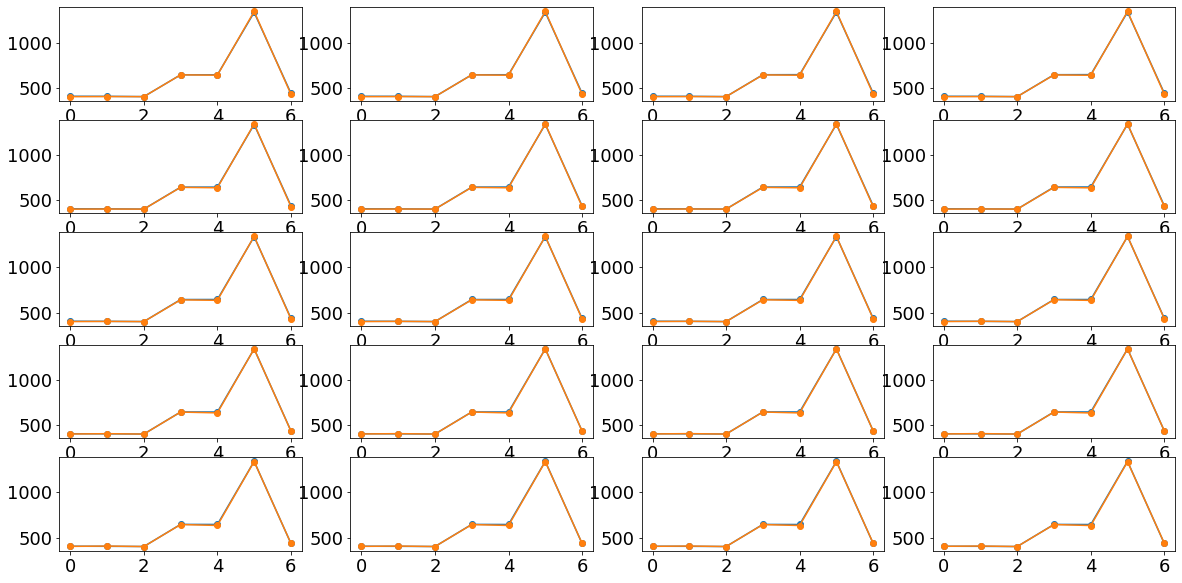

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[390+i,:], '-o')

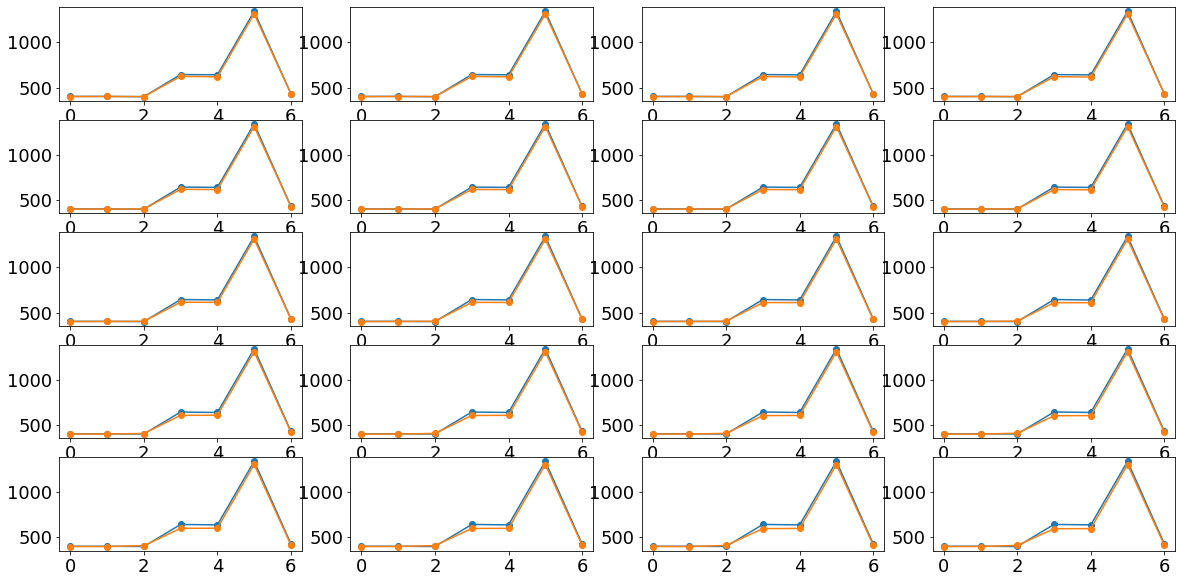

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[435+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[435+i,:], '-o')

Last DA pass

In [ ]:
GAN_inverse = scaler_minmax.inverse_transform(X_predict_forward_last)#.reshape((455,50))
# GAN_inverse = scaler_minmax.inverse_transform(X_predict_TEST).reshape((455,50))
print(GAN_inverse.shape)
split_inv = np.split(GAN_inverse, [43, ], axis=1)
alpha = split_inv[0]
print(alpha.shape)
sensor_CO2 = split_inv[-1]

print("GAN shape output of sensor CO2: ", sensor_CO2.shape)
 
X_recovered = pca.inverse_transform(alpha)
print(X_recovered.shape)

X_unscaled = np.split(X_recovered, [int(X_recovered.shape[-1]/4), int(X_recovered.shape[-1]/2), int(X_recovered.shape[-1]*(3/4)), ], axis=1)

norm_co2_ = scaler_std.inverse_transform(X_unscaled[0])
norm_x_ = scaler_x.inverse_transform(X_unscaled[1])
norm_y_ = scaler_y.inverse_transform(X_unscaled[2])
norm_z_ = scaler_z.inverse_transform(X_unscaled[-1])
norm_sensor_CO2_ = scaler_enhanced.inverse_transform(sensor_CO2)

print("norm_co2_ shape: ", norm_co2_.shape)
print("norm_z_ shape: ", norm_z_.shape)
print("norm_sensor_CO2_ shape: ", norm_sensor_CO2_.shape)

(455, 50)
(455, 43)
GAN shape output of sensor CO2:  (455, 7)
(455, 595624)
norm_co2_ shape:  (455, 148906)
norm_z_ shape:  (455, 148906)
norm_sensor_CO2_ shape:  (455, 7)


DA-pred results - time: 17:00pm, 09-08-2021


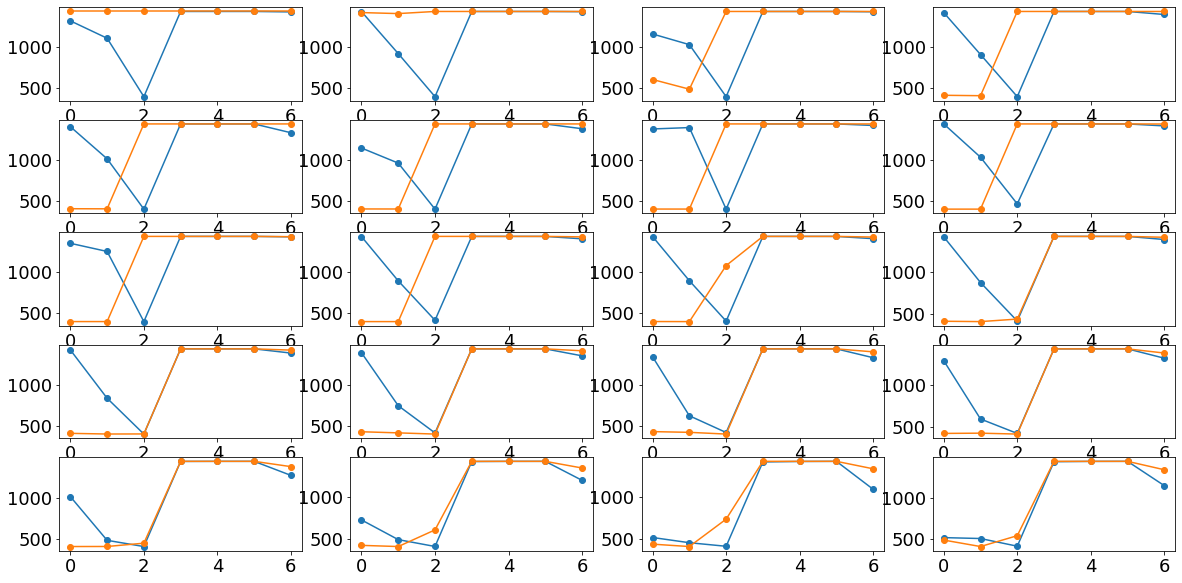

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[i,:], '-o')

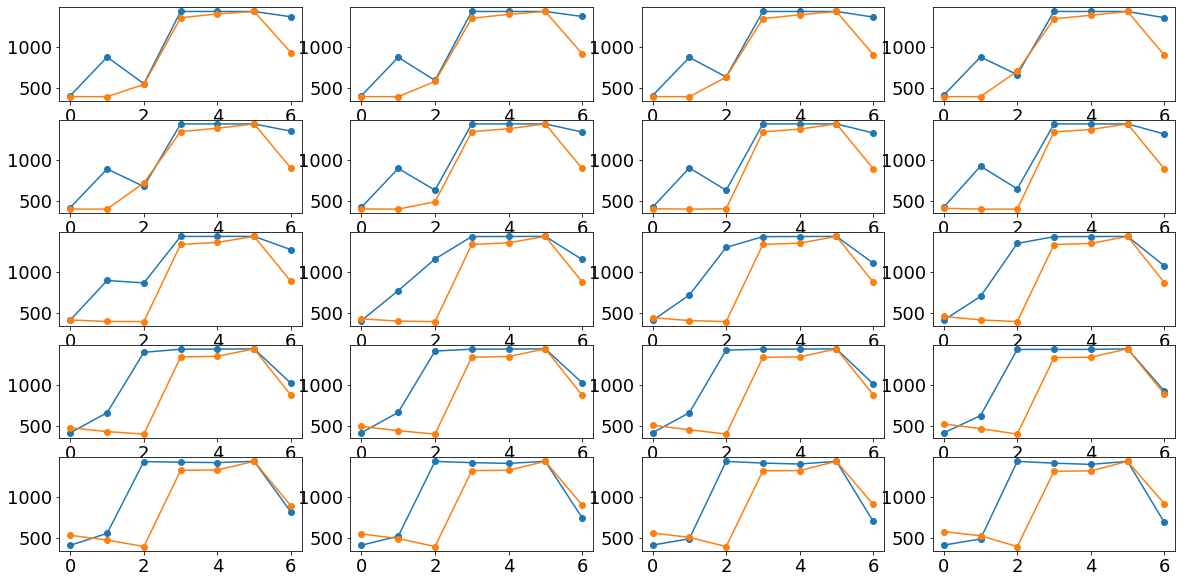

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[80+i,:], '-o')

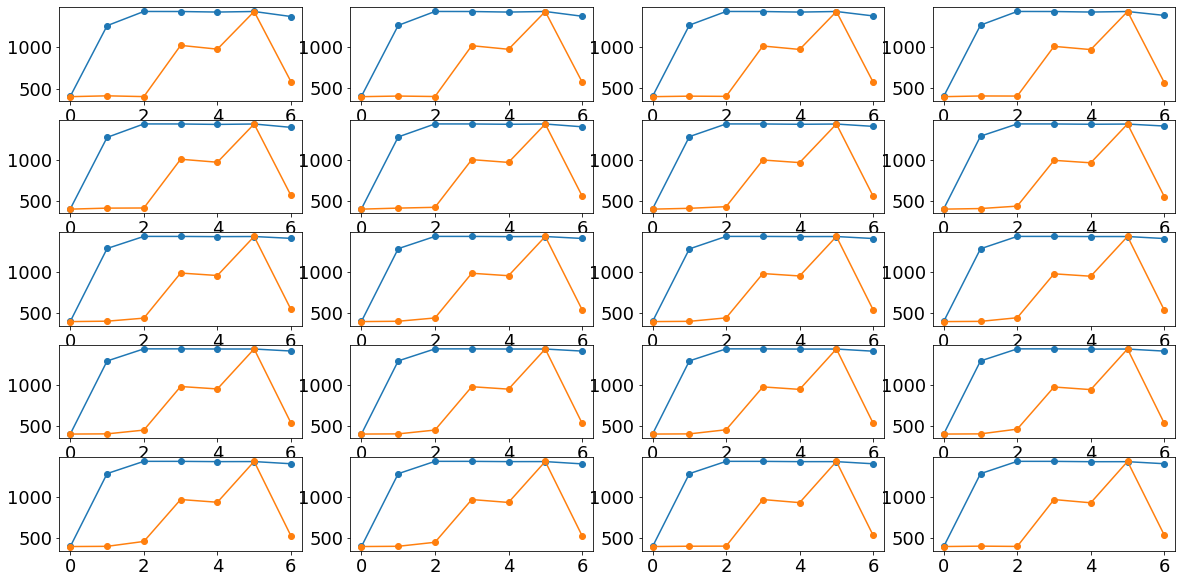

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[200+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[200+i,:], '-o')

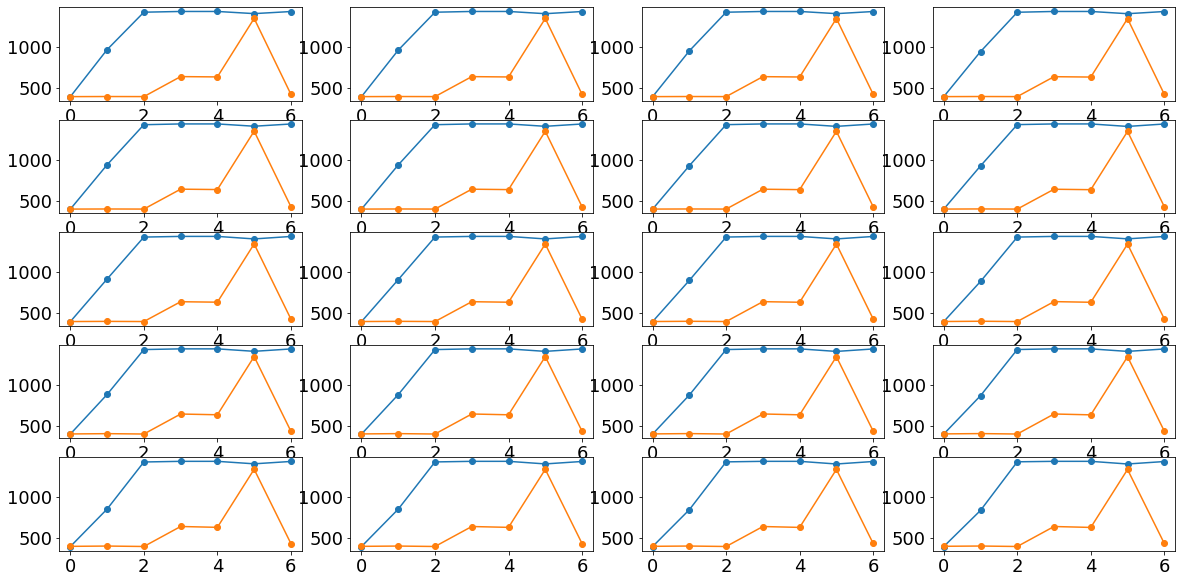

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[390+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[390+i,:], '-o')

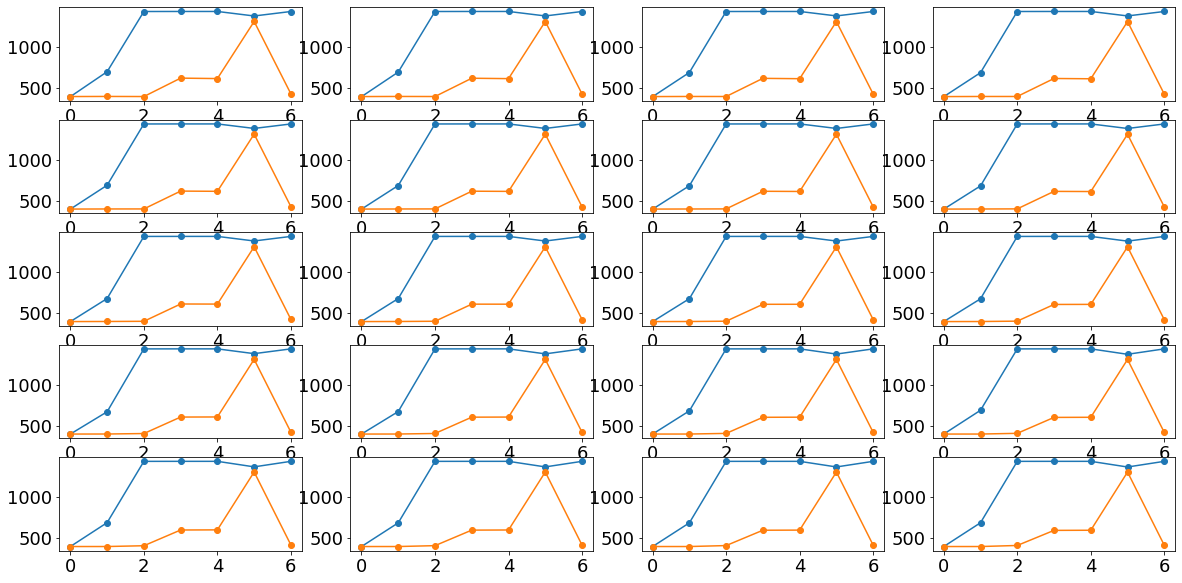

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[435+i,:], '-o')
    ax.flatten()[i].plot(CO2_sensor_all[435+i,:], '-o')

before DA

In [ ]:
def write_example_to_vtu(exm_num):
  # get clean vtu file
  snapshot_data_location = '/content/gdrive/MyDrive/ACSE-9/ClarenceCentre/run_Clip_ToSend/'
  snapshot_file_base = 'ClarenceCentre_'
  filename = snapshot_data_location + snapshot_file_base + '0.vtu'
  clean_vtu = get_clean_vtu_file(filename)

  # write results to vtu
  nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base)
  CO2_ppm = np.zeros((nNodes,1))
  velocity = np.zeros((nNodes,3))
  # sensor_CO2_ppm = np.zeros((7,1)) ## Dont need to add this to VTU

  new_vtu = vtktools.vtu()
  new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
  new_vtu.filename = '/content/gdrive/MyDrive/ACSE-9/DA-predictions/DA_prediction_' + str(exm_num) + '.vtu'

  CO2_ppm[:] = norm_co2_[exm_num].reshape((148906, 1),order='F')
  # for j in range(3):
  velocity[:,0] = norm_x_[exm_num].reshape((148906),order='F')
  velocity[:,1] = norm_y_[exm_num].reshape((148906),order='F') 
  velocity[:,2] = norm_z_[exm_num].reshape((148906),order='F')

  # sensor_CO2_ppm[:] = norm_sensor_CO2_[exm_num].reshape((7, 1), order='F') ## Dont need to add this to VTU


  new_vtu.AddField('CO2_ppm', CO2_ppm)
  new_vtu.AddField('Velocity', velocity)
  #new_vtu.AddField('Sensor_CO2_ppm', sensor_CO2_ppm) ## Dont need to add this field to VTU
  new_vtu.Write()

In [ ]:
# writing to vtu file
tic = time.time()
nVTU = X_recovered.shape[0] 
for i in range(nVTU):
  tic = time.time()
  write_example_to_vtu(i)
  toc = time.time()
  print("DA-PredGAN VTU file", i, "written in ", toc - tic, "seconds")
print("completed")

DA-PredGAN VTU file 0 written in  8.723011255264282 seconds


KeyboardInterrupt: ignored